<a href="https://colab.research.google.com/github/Ak3199/LineCloser_FullyCNN/blob/main/CNN_task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import cv2
from torch.utils.data import Dataset, DataLoader
from random import seed
import torch.nn as nn
import torch.optim as optim
import torch
import matplotlib.pyplot as plt
from torchvision.utils import save_image
import os
import numpy as np
import random
import torch.nn.functional as F
from PIL import Image
from tqdm.auto import tqdm
from time import sleep

##this is used to create the random lines on the image dataset

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
  def __init__(self, root_dir,mask_gen, transform=None):
    self.root_dir = root_dir
    self.transform = transform
    self.mask_gen=mask_gen
    self.images = []

    for filename in os.listdir(root_dir):
      if filename.endswith(".png"):
        self.images.append(os.path.join(root_dir, filename))

  def __len__(self):
    return len(self.images)
  
  def __getitem__(self, idx):
    image_path = self.images[idx]
    image = cv2.imread(image_path)
    image = cv2.resize(image, (256,256))/255.0
    masked_image,mask=self.mask_gen._generate_mask(image.copy())
    #masked_image=255-(255-image)*mask
    if self.transform:
      masked_image=torch.tensor(masked_image, dtype=torch.float32).permute(2,1,0)    
      image = torch.tensor(image,dtype=torch.float32).permute(2,1,0)

    return masked_image,image


In [ ]:
class MaskGenerator(object):
    def __init__(self, height, width, channels=3,
                 rand_seed=None, filepath=None):
        """Convenience functions for generating masks to be used for inpainting training
        Arguments:
            height {int} -- Mask height
            width {width} -- Mask width
        Keyword Arguments:
            channels {int} -- Channels to output (default: {3})
            rand_seed {[type]} -- Random seed (default: {None})
            filepath {[type]} -- Load masks from filepath. If None, generate masks with OpenCV (default: {None})
        """

        self.height = height
        self.width = width
        self.channels = channels
        self.filepath = filepath

        # If filepath supplied, load the list of masks within the directory
        self.mask_files = []
        if self.filepath:
            filenames = [f for f in os.listdir(self.filepath)]
            self.mask_files = [f for f in filenames
                               if any(filetype in f.lower()
                                      for filetype
                                      in ['.jpeg', '.png', '.jpg'])]
            print(">> Found {} masks in {}".format(len(self.mask_files),
                                                   self.filepath))

        # Seed for reproducibility
        if rand_seed:
            seed(rand_seed)

    def _generate_mask(self,img):
        """Generates a random irregular mask with lines, circles and elipses"""

        mask = np.zeros((self.height, self.width, self.channels), np.uint8)

        # Set size scale
        size = int((self.width + self.height) * 0.03)
        if self.width < 64 or self.height < 64:
            raise Exception("Width and Height of mask must be at least 64!")

        # Draw random lines
        for _ in range(random.randint(1, 10)):
            x1, x2 = random.randint(1, self.width), random.randint(1, self.width)
            y1, y2 = random.randint(1, self.height), random.randint(1, self.height)
            thickness = random.randint(3, size)
            cv2.line(img, (x1, y1), (x2, y2), (1, 1, 1), thickness)
            cv2.line(mask, (x1, y1), (x2, y2), (1, 1, 1), thickness)

        # Draw random circles
        for _ in range(random.randint(1, 10)):
            x1, y1 = random.randint(1, self.width), random.randint(1, self.height)
            radius = random.randint(3, size)
            cv2.circle(img, (x1, y1), radius, (1, 1, 1), -1)
            cv2.circle(mask, (x1, y1), radius, (1, 1, 1), -1)

        # Draw random ellipses
        for _ in range(random.randint(1, 20)):
            x1, y1 = random.randint(1, self.width), random.randint(1, self.height)
            s1, s2 = random.randint(1, self.width), random.randint(1, self.height)
            a1, a2, a3 = random.randint(3, 180), random.randint(3, 180), random.randint(3, 180)
            thickness = random.randint(3, size)
            cv2.ellipse(img, (x1, y1), (s1, s2), a1, a2, a3,
                        (1, 1, 1), thickness)
            cv2.ellipse(mask, (x1, y1), (s1, s2), a1, a2, a3,
                        (1, 1, 1), thickness)

        return img,mask

    def _load_mask(self, rotation=True, dilation=True, cropping=True):
        """Loads a mask from disk, and optionally augments it"""

        # Read image
        mask = cv2.imread(os.path.join(self.filepath, np.random.choice(
                                                        self.mask_files,
                                                        1,
                                                        replace=False
                                                        )[0]))

        # Random rotation
        if rotation:
            rand = np.random.random.randint(-180, 180)
            M = cv2.getRotationMatrix2D((mask.shape[1]/2, mask.shape[0]/2),
                                        rand, 1.5)
            mask = cv2.warpAffine(mask, M, (mask.shape[1], mask.shape[0]))

        # Random dilation
        if dilation:
            rand = np.random.random.randint(5, 47)
            kernel = np.ones((rand, rand), np.uint8)
            mask = cv2.erode(mask, kernel, iterations=1)

        # Random cropping
        if cropping:
            x = np.random.random.randint(0, mask.shape[1] - self.width)
            y = np.random.random.randint(0, mask.shape[0] - self.height)
            mask = mask[y:y+self.height, x:x+self.width]

        return (mask > 1).astype(np.uint8)

    def sample(self, random_seed=None):
        """Retrieve a random mask"""
        if random_seed:
            seed(random_seed)
        if self.filepath and len(self.mask_files) > 0:
            return self._load_mask()
        else:
            return self._generate_mask(img)


In [ ]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((352,352)),
    transforms.ToTensor(),
])

#enter the root directory and the batch size
trainset = CustomDataset(root_dir="/content/gdrive/MyDrive/CNN_task/ESB", mask_gen=MaskGenerator(256,256),transform=transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)

In [ ]:
valset = CustomDataset(root_dir = "/content/gdrive/MyDrive/CNN_task/MCB_hand", mask_gen = MaskGenerator(256,256), transform=transform)
valloader = DataLoader(valset, batch_size=32, shuffle = False)

In [ ]:
x,y=next(iter(trainloader))
x_val, y_val = next(iter(valloader))

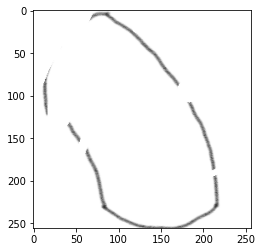

In [ ]:
plt.imshow(x[0].permute(2,1,0).detach().numpy())

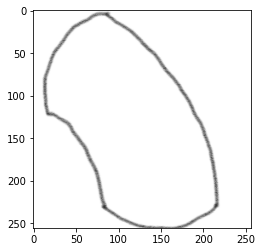

In [ ]:
plt.imshow(y[0].permute(2,1,0).detach().numpy())

##the model

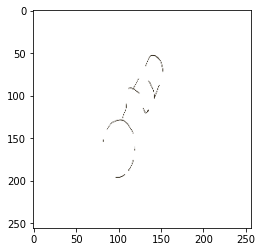

In [ ]:
plt.imshow(x_val[0].permute(2,1,0).detach().numpy())

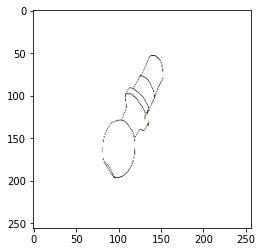

In [ ]:
plt.imshow(y_val[0].permute(2,1,0).detach().numpy())

In [ ]:
class ConvolutionalNeuralNet(nn.Module):
  def __init__(self):
    super(ConvolutionalNeuralNet, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=24, kernel_size=5, stride=2, padding=1)
    self.bn1 = nn.BatchNorm2d(24)
    self.relu1 = nn.ReLU()
    
    self.conv2 = nn.Conv2d(in_channels=24, out_channels=64, kernel_size=3, stride=2, padding=1)
    self.bn2 = nn.BatchNorm2d(64)
    self.relu2 = nn.ReLU()

    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
    self.bn3 = nn.BatchNorm2d(128)
    self.relu3 = nn.ReLU()

    self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1)
    self.bn4 = nn.BatchNorm2d(256)
    self.relu4 = nn.ReLU()

    self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
    self.bn5 = nn.BatchNorm2d(512)
    self.relu5 = nn.ReLU()

    self.conv6 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1)
    self.bn6 = nn.BatchNorm2d(512)
    self.relu6 = nn.ReLU()

    self.conv7 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1)
    self.bn7 = nn.BatchNorm2d(256)
    self.relu7 = nn.ReLU()

    self.upsample8 = nn.UpsamplingNearest2d(scale_factor=2)
    self.bnU8 = nn.BatchNorm2d(256)
    self.reluU8 = nn.ReLU()

    self.conv8 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1)
    self.bn8 = nn.BatchNorm2d(128)
    self.relu8 = nn.ReLU()

    self.conv9 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.bn9 = nn.BatchNorm2d(64)
    self.relu9 = nn.ReLU()

    self.upsample10 = nn.UpsamplingNearest2d(scale_factor=2)
    self.bnU10 = nn.BatchNorm2d(64)
    self.reluU10 = nn.ReLU()

    self.conv10 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride = 1, padding=1)
    self.bn10 = nn.BatchNorm2d(32)
    self.relu10 = nn.ReLU()

    self.conv11 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride = 1, padding=1)
    self.bn11 = nn.BatchNorm2d(16)
    self.relu11 = nn.ReLU()

    self.upsample12 = nn.UpsamplingNearest2d(scale_factor=2)
    self.bnU12 = nn.BatchNorm2d(16)
    self.reluU12 = nn.ReLU()

    self.conv12 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride = 1, padding=1)
    self.bn12 = nn.BatchNorm2d(8)
    self.relu12 = nn.ReLU()

    self.conv13 = nn.Conv2d(in_channels=8, out_channels=4, kernel_size=3, stride = 1, padding=1)
    self.bn13 = nn.BatchNorm2d(4)
    self.relu13 = nn.ReLU()

    self.upsample14 = nn.UpsamplingNearest2d(scale_factor=2)
    self.bnU14 = nn.BatchNorm2d(4)
    self.reluU14 = nn.ReLU()

    self.conv14 = nn.Conv2d(in_channels=4, out_channels=2, kernel_size=3, stride = 1, padding=1)
    self.bn14 = nn.BatchNorm2d(2)
    self.relu14 = nn.ReLU()

    self.conv15 = nn.Conv2d(in_channels=2, out_channels=1, kernel_size=3, stride = 1, padding=1)
    self.bn15 = nn.BatchNorm2d(1)
    self.relu15 = nn.ReLU()

    self.conv16 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride = 1, padding=1)
    self.sigmoid16 = nn.Sigmoid()

  def forward(self,x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu1(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu2(x)

    x = self.conv3(x)
    x = self.bn3(x)
    x = self.relu3(x)

    x = self.conv4(x)
    x = self.bn4(x)
    x = self.relu4(x)

    x = self.conv5(x)
    x = self.bn5(x)
    x = self.relu5(x)

    x = self.conv6(x)
    x = self.bn6(x)
    x = self.relu6(x)

    x = self.conv7(x)
    x = self.bn7(x)
    x = self.relu7(x)

    x = self.upsample8(x)
    x = self.bnU8(x)
    x = self.reluU8(x)

    x = self.conv8(x)
    x = self.bn8(x)
    x = self.relu8(x)

    x = self.conv9(x)
    x = self.bn9(x)
    x = self.relu9(x)

    x = self.upsample10(x)
    x = self.bnU10(x)
    x = self.reluU10(x)

    x = self.conv10(x)
    x = self.bn10(x)
    x = self.relu10(x)

    x = self.conv11(x)
    x = self.bn11(x)
    x = self.relu11(x)

    x = self.upsample12(x)
    x = self.bnU12(x)
    x = self.reluU12(x)

    x = self.conv12(x)
    x = self.bn12(x)
    x = self.relu12(x)

    x = self.conv13(x)
    x = self.bn13(x)
    x = self.relu13(x)

    x = self.upsample14(x)
    x = self.bnU14(x)
    x = self.reluU14(x)

    x = self.conv14(x)
    x = self.bn14(x)
    x = self.relu14(x)

    x = self.conv15(x)
    x = self.bn15(x)
    x = self.relu15(x)

    x = self.conv16(x)
    output_tensor = self.sigmoid16(x)
    
    return output_tensor

model = ConvolutionalNeuralNet()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to("cuda:0")

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [ ]:
for epoch in tqdm(range(300)):
  sleep(0.1)
  running_loss = 0.0
  for i, (x, y) in enumerate(trainloader):
    x = x.to(device).float()
    y = y.to(device).float()
    y_pred = model(x)
    loss = criterion(y, y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

    if i % 1000 == 999:
      last_loss = running_loss / 1000 # loss per batch
      print('  batch {} loss: {}'.format(i + 1, last_loss))
    i+=1
  x,y = next(iter(trainloader))
  x = x.to(device).float()
  y_pred = model(x)
  save_image(y_pred, '/content/gdrive/MyDrive/CNN_task/ESB_pred_reduced_masking_LR/'+str(epoch)+'.png')

In [ ]:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/CNN_task/model_weight_reduced_masking_LR.pth')

testing

In [ ]:
model = ConvolutionalNeuralNet().to(device)
model.load_state_dict(torch.load('/content/gdrive/MyDrive/CNN_task/model_weight_reduced_masking_LR.pth'))

<All keys matched successfully>

In [ ]:
with torch.no_grad():
  for i,(x_test,y_test) in enumerate(valloader):
    x_test=x_test.to(device).float()
    y_test = y_test.to(device).float()
    y_test_pred = model(x_test)
    save_image(y_test_pred, '/content/gdrive/MyDrive/CNN_task/MCB_test_reduced_masking_LR/'+ str(i+1)+'.png')